##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom Federated Algorithms, Part 2: Implementing Federated Averaging

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.4.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.4.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial is the second part of a two-part series that demonstrates how to
implement custom types of federated algorithms in TFF using the
[Federated Core (FC)](../federated_core.md), which serves as a foundation for
the [Federated Learning (FL)](../federated_learning.md) layer (`tff.learning`).

We encourage you to first read the
[first part of this series](custom_federated_algorithms_1.ipynb), which
introduce some of the key concepts and programming abstractions used here.

This second part of the series uses the mechanisms introduced in the first part
to implement a simple version of federated training and evaluation algorithms.

We encourage you to review the
[image classification](federated_learning_for_image_classification.ipynb) and
[text generation](federated_learning_for_text_generation.ipynb) tutorials for a
higher-level and more gentle introduction to TFF's Federated Learning APIs, as
they will help you put the concepts we describe here in context.

## Before we start

Before we start, try to run the following "Hello World" example to make sure
your environment is correctly setup. If it doesn't work, please refer to the
[Installation](../install.md) guide for instructions.

In [1]:
#@test {"skip": true}

# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

#!pip install tensorflow_federated

In [2]:
from __future__ import absolute_import, division, print_function

import collections
import numpy as np
from six.moves import range
import tensorflow as tf
from tensorflow.keras import layers
import datetime
from numpy.random import seed
seed(42)

from absl import app
from absl import flags

from sklearn.model_selection import train_test_split

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data
from tensorflow_federated import python as tff

tf.compat.v1.enable_v2_behavior()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'


hello_world()

'Hello, World!'

## Implementing Federated Averaging

As in
[Federated Learning for Image Classification](federated_learning_for_image_classification.md),
we are going to use the MNIST example, but since this is intended as a low-level
tutorial, we are going to bypass the Keras API and `tff.simulation`, write raw
model code, and construct a federated data set from scratch.



### Preparing federated data sets

For the sake of a demonstration, we're going to simulate a scenario in which we
have data from 10 users, and each of the users contributes knowledge how to
recognize a different digit. This is about as
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
as it gets.

First, let's load the standard MNIST data:

In [4]:
#@test {"output": "ignore"}
cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [359]:
# cifar_test = (cifar_test[0], tf.keras.utils.to_categorical(cifar_test[1]))
# cifar_train = (cifar_train[0], tf.keras.utils.to_categorical(cifar_train[1]))

In [360]:
[x.shape for x in cifar_train]

[(50000, 32, 32, 3), (50000, 1)]

In [503]:
[x.shape for x in cifar_test]

[(10000, 32, 32, 3), (10000, 1)]

The data comes as Numpy arrays, one with images and another with digit labels, both
with the first dimension going over the individual examples. Let's write a
helper function that formats it in a way compatible with how we feed federated
sequences into TFF computations, i.e., as a list of lists - the outer list
ranging over the users (digits), the inner ones ranging over batches of data in
each client's sequence. As is customary, we will structure each batch as a pair
of tensors named `x` and `y`, each with the leading batch dimension. While at
it, we'll also flatten each image into a 784-element vector and rescale the
pixels in it into the `0..1` range, so that we don't have to clutter the model
logic with data conversions.

In [25]:
NUM_EXAMPLES_PER_USER = 2000
BATCH_SIZE = 32
USERS = 5
NUM_EPOCHS = 4
CLASSES = 10


def get_indices_unbalanced_completely(y):
    # split dataset into arrays of each class label
    indices_array = []
    for c in range(CLASSES):
        indices_array.append([i for i, d in enumerate(y) if d == c])
    class_shares = CLASSES // min(CLASSES, USERS)
    user_indices = []
    for u in range(USERS):
        user_indices.append(
            np.array(
                [indices_array.pop(0)[:NUM_EXAMPLES_PER_USER//class_shares] for j in range(class_shares)])
            .flatten())
    return user_indices

def get_indices_unbalanced(y):
    # split dataset into arrays of each class label
    indices_array = []
    for c in range(CLASSES):
        indices_array.append([i for i, d in enumerate(y) if d == c])
    # each user will have 2 classes excluded from their data sets, thus 250 examples * remaining 8 classes
    class_shares = 250
    # store indices for future use
    user_indices = []
    # auxilary index array to pop out pairs of classes missing at each user
    class_index = list(range(CLASSES))
    for u in range(USERS):
        columns_out = [class_index.pop(0) for i in range(2)]
        selected_columns = set(range(CLASSES)) - set(columns_out)
        starting_index = u*class_shares
        user_indices.append(
            np.array(indices_array)[list(selected_columns)].T[starting_index:starting_index + class_shares]
            .flatten())
    return user_indices

def get_indices_realistic(y, u):
    # split dataset into arrays of each class label
    all_indices = [i for i, d in enumerate(y)]
    shares_arr = [5000, 3000, 1000, 750, 250]
    user_indices = []
    for u in range(USERS):
        user_indices.append([all_indices.pop(0) for i in range(shares_arr[u])]) 
    return user_indices

def get_indices_even(y):
    # split dataset into arrays of each class label
    indices_array = []
    for c in range(CLASSES):
        indices_array.append([i for i, d in enumerate(y) if d == c])
    user_indices = []
    class_shares = NUM_EXAMPLES_PER_USER // CLASSES
    
    # take even shares of each class for every user
    for u in range(USERS):
        starting_index = u*class_shares
        user_indices.append(np.array(indices_array).T[starting_index:starting_index + class_shares].flatten())   
    return user_indices

def get_non_distributed(source):
    indices = np.concatenate(get_indices_even(source[1]))
    y = np.array(source[1][indices], dtype=np.int32)
    X = np.array(source[0][indices], dtype=np.float32) / 255.0
    return X, y
    
def get_distributed(source, u, distribution):
    if distribution == 'i':
        indices = get_indices_even(source[1])[u]
    elif distribution == 'n':
        indices = get_indices_unbalanced(source[1])[u]
    elif distribution == 'r':
        indices = get_indices_realistic(source[1][:10000], u)[u]
    else:
        indices = np.array(get_indices_unbalanced_completely(source[1])[u])
    
    output_sequence = []
    for repeat in range(NUM_EPOCHS):
        for i in range(0, len(indices), BATCH_SIZE):
            batch_samples = indices[i:i + BATCH_SIZE]
            output_sequence.append({
                'x': np.array([source[0][b] / 255.0 for b in batch_samples], dtype=np.float32),
                'y': np.array([source[1][b] for b in batch_samples], dtype=np.int32)})
    return output_sequence


federated_train_data = [get_distributed(cifar_train, u, 'i') for u in range(USERS)]
federated_test_data = [get_distributed(cifar_test, u, 'i') for u in range(USERS)]

(X, y) = get_non_distributed(cifar_train)
(X_test, y_test) = get_non_distributed(cifar_test)


In [1]:
y_test.shape

NameError: name 'y_test' is not defined

In [688]:
len(federated_train_data[0])

157

In [6]:
sample_batch = federated_train_data[1][-2]
sample_batch['x'].shape

(32, 32, 32, 3)

As a quick sanity check, let's look at the `Y` tensor in the last batch of data
contributed by the fifth client (the one corresponding to the digit `5`).

Just to be sure, let's also look at the image corresponding to the last element of that batch.

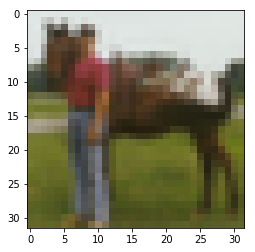

In [7]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt
%matplotlib inline
#print(cifar_class_labels[federated_train_data[4][5]['y'][-5][0]])
plt.imshow(federated_train_data[4][5]['x'][-5].reshape(32, 32, 3))
#plt.imshow(cifar_train[0][4])
plt.grid(False)
plt.show()

# Creating a model with Keras

In [7]:
WIDTH = 32
HEIGHT = 32
CHANNELS = 3

from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow.keras import layers

def create_compiled_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="tanh",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="tanh", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation="tanh"),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    
    def loss_fn(y_true, y_pred):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred))
    
    model.compile(
      loss=loss_fn,
      optimizer="adam",
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

# Non-federated keras model

In [23]:
non_federated_model = create_compiled_keras_model()

In [718]:
history_callback = non_federated_model.fit(X, y, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 23s 2ms/sample - loss: 1.6453 - categorical_accuracy: 0.4105 - val_loss: 1.4564 - val_categorical_accuracy: 0.4887
Epoch 2/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.2948 - categorical_accuracy: 0.5413 - val_loss: 1.3070 - val_categorical_accuracy: 0.5377
Epoch 3/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.0989 - categorical_accuracy: 0.6127 - val_loss: 1.2251 - val_categorical_accuracy: 0.5706
Epoch 4/50
10000/10000 [==============================] - 18s 2ms/sample - loss: 0.9609 - categorical_accuracy: 0.6592 - val_loss: 1.2384 - val_categorical_accuracy: 0.5791
Epoch 5/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 0.8286 - categorical_accuracy: 0.7077 - val_loss: 1.2404 - val_categorical_accuracy: 0.5842
Epoch 6/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 0.69

10000/10000 [==============================] - 15s 2ms/sample - loss: 2.0279e-05 - categorical_accuracy: 1.0000 - val_loss: 2.7009 - val_categorical_accuracy: 0.6002
Epoch 48/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.7068e-05 - categorical_accuracy: 1.0000 - val_loss: 2.7247 - val_categorical_accuracy: 0.5999
Epoch 49/50
10000/10000 [==============================] - 19s 2ms/sample - loss: 1.4409e-05 - categorical_accuracy: 1.0000 - val_loss: 2.7476 - val_categorical_accuracy: 0.5995
Epoch 50/50
10000/10000 [==============================] - 20s 2ms/sample - loss: 1.2274e-05 - categorical_accuracy: 1.0000 - val_loss: 2.7663 - val_categorical_accuracy: 0.5997


In [282]:
test_accuracy = history_callback.history['loss']
test_accuracy

[1.6563694650650025,
 1.3007290199279786,
 1.1194022260665895,
 0.9801722335815429,
 0.8453258259773254,
 0.7207920631408692,
 0.569933446264267,
 0.42374285163879394,
 0.30032064225673677,
 0.19598041729927063,
 0.11359974697828293,
 0.0627660088956356]

In [438]:
non_federated_model.save("non_federated_cifar10.h5")

In [719]:
try:
    with open('Log/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, Non-federated, IDD, minibatch_size: 32", file=log)
        print("NFTrain = {}".format(history_callback.history["loss"]), file=log)
        print("NFTest = {}".format(history_callback.history["val_loss"]), file=log)
        print("NFAccuracy = {}".format(history_callback.history["val_categorical_accuracy"]), file=log)
                
except IOError:
    print('File Error')

# Federated Model

In [26]:
def model_fn():
    keras_model = create_compiled_keras_model()
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [27]:
#@test {"output": "ignore"}
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

In [28]:
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [52]:
# One round / one user test
state = iterative_process.initialize()
state, metrics = iterative_process.next(state, federated_train_data[0:1])
# test_metrics = evaluation(state.model, federated_test_data)
non_federated_model.set_weights(state.model.trainable)
(loss, accuracy) = non_federated_model.evaluate(X_test, y_test)
print('round  1, metrics={}'.format(metrics))
print('test accuracy: {}'.format(accuracy))

10000/10000 [==============================] - 4s 442us/sample - loss: 1.6801 - sparse_categorical_accuracy: 0.4095
round  1, metrics=<sparse_categorical_accuracy=0.3275,loss=1.8733339>
test accuracy: 0.40950000286102295


In [ ]:
#@test {"skip": true}
epochs = 12
state = iterative_process.initialize()
fd_test_loss = []
fd_train_loss = []
fd_train_accuracy = []
for round_num in range(12):
    selected = np.random.choice(5, 5, replace=False)
    state, metrics = iterative_process.next(state, list(np.array(federated_train_data)[selected]))
#     non_federated_model.set_weights(state.model.trainable)
#     fd_train_loss.append(metrics[1])
#     fd_test_accuracy.append(accuracy)
#     fd_test_loss.append(loss)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

In [58]:
fd_test_accuracy

[0.4527,
 0.4398,
 0.4791,
 0.5053,
 0.5295,
 0.5456,
 0.5595,
 0.5747,
 0.5807,
 0.5853,
 0.5906,
 0.5918,
 0.5935,
 0.4413,
 0.4805,
 0.5017,
 0.5206,
 0.5365,
 0.5511,
 0.5626,
 0.5729,
 0.5803,
 0.5867,
 0.5858,
 0.5863]

In [264]:
non_federated_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 5s 504us/sample - loss: 2.0773 - sparse_categorical_accuracy: 0.6001


[2.0773194374084474, 0.6001]

In [272]:
non_federated_model.set_weights(tff.learning.keras_weights_from_tff_weights(state.model))
non_federated_model.save('')

10000/10000 [==============================] - 4s 360us/sample - loss: 1.2888 - sparse_categorical_accuracy: 0.5730


[1.2887664936065675, 0.573]

In [30]:
selected = np.random.choice(5, 4, replace=False)
len(list(np.array(federated_train_data)[selected]))

4

In [351]:
try:
    with open('Log/Exp5/niiE2C2.txt', 'w') as log:
        print("Cifar10, Federated E2C2, non-IDD, minibatch_size: 32", file=log)
        print("Train Loss: {}".format(fd_train_loss), file=log)
        print("Test Accuracy: {}".format(fd_test_accuracy), file=log)
                
except IOError:
    print('File Error')

# Membership Inference Attach (MIA)

In [12]:
import numpy as np
from numpy.random import seed
seed(42)

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

In [13]:
NUM_CLASSES = 10
WIDTH = 32
HEIGHT = 32
CHANNELS = 3
SHADOW_DATASET_SIZE = 1000
ATTACK_TEST_DATASET_SIZE = 4000


target_epochs = 12
attack_epochs = 12
num_shadows = 10

In [16]:
def target_model_fn():
    """The architecture of the target (victim) model.

    The attack is white-box, hence the attacker is assumed to know this architecture too."""

    model = tf.keras.models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (3, 3),
            activation="tanh",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS),
        )
    )
    #model.add(layers.Conv2D(32, (3, 3), activation="tanh"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation="tanh", padding="same"))
    #model.add(layers.Conv2D(64, (3, 3), activation="tanh"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="tanh"))
    #model.add(layers.Dropout(0.5))

    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.

    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [19]:
target_model = load_model('non_federated_cifar10.h5')
y = tf.keras.utils.to_categorical(y)
y_test = tf.keras.utils.to_categorical(y_test)

In [20]:
# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=num_shadows
)

# Using cifar10 test set to train shadow models
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    X_test, y_test, test_size=0.5)

print(attacker_X_train.shape, attacker_X_test.shape)

print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=target_epochs,
        verbose=True,
        validation_data=(attacker_X_test, attacker_y_test)
    )
)

(5000, 32, 32, 3) (5000, 32, 32, 3)
Training the shadow models...
Train on 1000 samples, validate on 5000 samples
Epoch 1/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.1514 - acc: 0.2390 - val_loss: 1.8460 - val_acc: 0.3520
Epoch 2/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.7084 - acc: 0.3960 - val_loss: 1.7144 - val_acc: 0.4000
Epoch 3/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.5218 - acc: 0.4870 - val_loss: 1.8279 - val_acc: 0.3628
Epoch 4/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.3486 - acc: 0.5540 - val_loss: 1.6742 - val_acc: 0.4198
Epoch 5/12
1000/1000 [==============================] - 6s 6ms/sample - loss: 1.1761 - acc: 0.6220 - val_loss: 1.6894 - val_acc: 0.4090
Epoch 6/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.0216 - acc: 0.6720 - val_loss: 1.7723 - val_acc: 0.3964
Epoch 7/12
1000/1000 [==============================] - 5s 5ms/sample 

Epoch 11/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.3578 - acc: 0.9250 - val_loss: 2.0819 - val_acc: 0.3988
Epoch 12/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.2724 - acc: 0.9430 - val_loss: 2.1703 - val_acc: 0.3900
Train on 1000 samples, validate on 5000 samples
Epoch 1/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.1744 - acc: 0.2320 - val_loss: 1.8765 - val_acc: 0.3460
Epoch 2/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.6935 - acc: 0.4120 - val_loss: 1.7020 - val_acc: 0.3980
Epoch 3/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.5055 - acc: 0.4820 - val_loss: 1.6957 - val_acc: 0.3896
Epoch 4/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.3498 - acc: 0.5350 - val_loss: 1.7554 - val_acc: 0.3886
Epoch 5/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.2239 - acc: 0.5790 - val_loss: 1.6528 - val_acc: 0.419

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.5742 - acc: 0.8550 - val_loss: 1.8565 - val_acc: 0.4186
Epoch 10/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.4391 - acc: 0.8940 - val_loss: 1.8557 - val_acc: 0.4244
Epoch 11/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.3258 - acc: 0.9390 - val_loss: 2.0200 - val_acc: 0.4128
Epoch 12/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.2361 - acc: 0.9640 - val_loss: 2.0403 - val_acc: 0.4264


In [21]:
# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(X_shadow, y_shadow, fit_kwargs=dict(epochs=attack_epochs, verbose=True)
)

Training the attack models...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0701 10:00:19.899251 4588352960 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/12
1978/1978 [==============================] - 1s 329us/sample - loss: 0.5788 - acc: 0.7361
Epoch 2/12
1978/1978 [==============================] - 0s 99us/sample - loss: 0.4824 - acc: 0.7735
Epoch 3/12
1978/1978 [==============================] - 0s 90us/sample - loss: 0.4785 - acc: 0.7730
Epoch 4/12
1978/1978 [==============================] - 0s 70us/sample - loss: 0.4723 - acc: 0.7801
Epoch 5/12
1978/1978 [==============================] - 0s 52us/sample - loss: 0.4683 - acc: 0.7705
Epoch 6/12
1978/1978 [==============================] - 0s 49us/sample - loss: 0.4735 - acc: 0.7786
Epoch 7/12
1978/1978 [==============================] - 0s 48us/sample - loss: 0.4643 - acc: 0.7816
Epoch 8/12
1978/1978 [==============================] - 0s 49us/sample - loss: 0.4659 - acc: 0.7725
Epoch 9/12
1978/1978 [==============================] - 0s 57us/sample - loss: 0.4645 - acc: 0.7710
Epoch 10/12
1978/1978 [==============================] - 0s 70us/sample - loss: 0.4628 - acc: 0.776

1936/1936 [==============================] - 0s 86us/sample - loss: 0.4420 - acc: 0.8017
Epoch 11/12
1936/1936 [==============================] - 0s 66us/sample - loss: 0.4388 - acc: 0.7986
Epoch 12/12
1936/1936 [==============================] - 0s 70us/sample - loss: 0.4389 - acc: 0.7949
Epoch 1/12
2130/2130 [==============================] - 1s 483us/sample - loss: 0.5932 - acc: 0.7000
Epoch 2/12
2130/2130 [==============================] - 0s 146us/sample - loss: 0.4590 - acc: 0.7845
Epoch 3/12
2130/2130 [==============================] - 1s 273us/sample - loss: 0.4484 - acc: 0.7915
Epoch 4/12
2130/2130 [==============================] - 0s 134us/sample - loss: 0.4417 - acc: 0.7930
Epoch 5/12
2130/2130 [==============================] - 0s 121us/sample - loss: 0.4459 - acc: 0.7897
Epoch 6/12
2130/2130 [==============================] - 0s 107us/sample - loss: 0.4417 - acc: 0.7920
Epoch 7/12
2130/2130 [==============================] - 0s 116us/sample - loss: 0.4430 - acc: 0.7892
Ep

In [93]:

target_model.set_weights(state.model.trainable)


In [94]:
from sklearn.metrics import precision_score
# Test the success of the attack.
# Prepare examples that were in the training, and out of the training.

mia_accuracy = []
mia_precision = []

for c in range(CLASSES):
    target_indices = [i for i, d in enumerate(np.argmax(y, axis=1)) if d == c]
    test_indices = [i for i, d in enumerate(np.argmax(attacker_y_test, axis=1)) if d == c]
    data_in = [X[target_indices], y[target_indices]]
    data_out = [[attacker_X_test[test_indices]], attacker_y_test[test_indices]]

    # Compile them into the expected format for the AttackModelBundle.
    attack_test_data, real_membership_labels = prepare_attack_data(
        target_model, data_in, data_out
    )

    # Compute the attack accuracy.
    attack_guesses = amb.predict(attack_test_data)
    attack_accuracy = np.mean(attack_guesses == real_membership_labels)
    mia_accuracy.append(attack_accuracy)
    mia_precision.append(precision_score(real_membership_labels, attack_guesses))
print(mia_accuracy)
print(mia_precision)

[0.567003367003367, 0.566622691292876, 0.5532194480946123, 0.4868073878627968, 0.542225201072386, 0.5072751322751323, 0.5129427792915532, 0.5383064516129032, 0.5513333333333333, 0.5749500333111259]
[0.7007874015748031, 0.7162673392181589, 0.7325581395348837, 0.7803030303030303, 0.7536, 0.7272727272727273, 0.7209302325581395, 0.7194950911640954, 0.7036114570361146, 0.760806916426513]


In [703]:
try:
    with open('Log/MIA/rE2C2.txt', 'w') as log:
        print("rE2C2acc = {}".format(mia_accuracy), file=log)
        print("rE2C2pre = {}".format(mia_precision), file=log)
                
except IOError:
    print('File Error')

In [34]:
np.average([0.7695852534562212, 0.7829560585885486, 0.8656618610747051, 0.8687206965840589, 0.8522954091816367, 0.8390646492434664, 0.7910643889618922, 0.807277628032345, 0.7960396039603961, 0.7948717948717948])

0.8167537343955065

In [69]:
np.average([0.7021517553793885, 0.7156398104265402, 0.7280701754385965, 0.7718832891246684, 0.741307371349096, 0.7302504816955684, 0.7214885954381752, 0.7171428571428572, 0.7144535840188014, 0.7539797395079595])

0.7296367659521652

In [426]:
np.argmax(y, axis=1)

array([0, 1, 2, ..., 7, 8, 9])

In [ ]:
<conv2d/kernel=[[[[-5.42145409e-02 -9.29415375e-02  9.59848799e-03 -1.24651883
    -4.74597374e-03  6.39463514e-02  7.72277191e-02 -6.19306117e-02
     1.12236537e-01 -9.36510563e-02  9.26551670e-02  8.08892250e-02
    -1.36332000e-02 -7.95079619e-02 -6.24745712e-02  1.12114482e-01
     7.13181347e-02 -5.21638282e-02  1.27013907e-01 -1.14578225e-01
     6.35279119e-02  1.11849017e-01 -7.88050294e-02  2.95140538e-02
    -2.79310048e-02 -1.47477508e-01 -8.70073959e-02  5.86430654e-02
     3.71561968e-04  7.01781064e-02  1.18049368e-01  8.97085816e-02]
   [ 1.30100861e-01 -3.27671580e-02  1.19756632e-01 -1.42253444e-01
    -1.02145381e-01  8.69416911e-03  3.48152928e-02  1.01850023e-02
    -9.14086178e-02 -3.09834778e-02 -6.95866793e-02 -2.65930369e-02
     2.75183469e-03 -9.73303542e-02  1.05238795e-01 -5.39357290e-02
    -8.16846713e-02  7.36190155e-02 -4.24497686e-02  6.97964653e-02
     3.57606560e-02 -1.14507638e-01 -9.91197024e-03  3.90822105e-02
    -1.09545747e-02 -2.22205427e-02  4.85142171e-02 -2.42610071e-02
    -9.69229490e-02 -3.09411883e-02 -9.12560746e-02 -8.95848572e-02]
   [ 8.69994611e-03 -6.94726855e-02 -1.32288700e-02 -5.20821698e-02
     9.10899714e-02 -1.21620931e-01  7.07676709e-02 -9.30615235e-04
     7.55560547e-02  8.09496716e-02  3.51783223e-02 -3.14740092e-02
    7.05207363e-02 -4.19138856e-02 -7.14744478e-02  2.24497169e-02
     4.06181552e-02 -1.40542030e-01 -1.37560964e-01  1.03260078e-01
     5.35405315e-02  2.68804077e-02 -5.61432987e-02  9.36878845e-02
    -1.06399521e-01 -5.91180474e-02 -1.88456737e-02 -3.25000919e-02
     8.84265006e-02  1.40605614e-01 -1.19070061e-01 -3.89880836e-02]]

  [[ 9.04263332e-02  7.62202963e-02  5.33219166e-02 -6.59058453e-04
    -4.14211676e-02 -6.37268350e-02 -1.00701481e-01 -5.83394282e-02
    -2.31314227e-02  2.32471675e-02 -1.01180360e-01  7.85506517e-02
    -9.31655094e-02  1.10249102e-01  7.13690519e-02  8.32763091e-02
    -9.46618468e-02  2.16780808e-02 -4.85283621e-02  2.55225040e-02
     3.09757367e-02 -8.94018561e-02 -1.51236150e-02  9.61311162e-02
    -7.54762068e-02 -5.42784818e-02 -2.63635311e-02  1.56526789e-02
    -4.46861126e-02 -1.02023780e-01  1.16602696e-01 -4.11380455e-02]
   [ 3.15265842e-02  1.18916936e-01 -7.81858712e-02 -8.60707834e-02
    -9.52330232e-02 -5.93867563e-02  1.63705945e-02  1.08087242e-01
     2.07749587e-02  3.70924966e-03  1.82045344e-02 -7.39347115e-02
    -3.37157436e-02  1.39418036e-01 -3.82396206e-02 -5.40040396e-02
     2.98683136e-03  1.03068948e-01 -1.04710817e-01 -1.93764158e-02
    -1.32776611e-02 -3.73043008e-02 -6.90225735e-02  3.32656354e-02
    -2.53778649e-03 -5.25377169e-02 -8.16403404e-02 -5.89925870e-02
     1.53077155e-01  3.53813022e-02 -5.37460223e-02  7.87424296e-02]
   [ 1.45501345e-02 -3.77694666e-02 -7.15423422e-03 -1.03167430e-01
    -1.09158896e-01 -3.68729122e-02  1.14286393e-01 -1.36856660e-01
    -4.26050508e-03  9.36951563e-02 -1.01519845e-01  1.52138695e-01
     8.83981436e-02  5.20503595e-02 -1.18898429e-01  1.15645960e-01
    -1.18085600e-01 -1.52510509e-01 -7.79650360e-02 -5.74325072e-03
     4.25417349e-02 -4.51641008e-02 -4.90775257e-02 -3.62045281e-02
    -5.01497015e-02 -1.51180755e-02  1.27451643e-01  3.49950306e-02
    -2.29743831e-02  5.81850111e-03 -8.78469869e-02 -1.35514066e-01]]
                 [[ 2.43675094e-02 -1.78505890e-02  1.10490210e-01 -1.15350552e-01
    -7.09867850e-02  8.19782764e-02  9.13404822e-02  6.22468181e-02
    -1.27217427e-01  5.40355332e-02  2.51856614e-02 -1.03047401e-01
    -1.04841396e-01 -1.02888949e-01  1.77751761e-02  2.37558000e-02
    -6.10768311e-02  1.27097949e-01 -9.89521816e-02 -1.05360396e-01
     8.35644305e-02 -2.36028749e-02  7.65823424e-02 -4.81431447e-02
     3.48126516e-02 -1.00858532e-01 -6.14999942e-02 -3.01653203e-02
     3.02533917e-02  3.82566974e-02  2.90715750e-02 -1.15484178e-01]
   [-1.17214173e-01 -1.11008277e-02 -4.84149754e-02 -1.04862235e-01